# Time Series of YCSD Covid Case Metric

This notebook examines the time series of the York County COVID Cases ostensibly used by YCSD to make decisions about school reopenings.

* YCSD presents there metrics on https://ycsd.yorkcountyschools.org/domain/1313
* VDH represents the this number for the localities on https://www.vdh.virginia.gov/coronavirus/coronavirus/covid-19-in-virginia-locality/ and on https://www.vdh.virginia.gov/coronavirus/key-measures/pandemic-metrics/school-metrics/ under the localities tab
* VDH shares the data at https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr
* I'm sharing This notebook in Github at https://github.com/drf5n/YCSD_covid_metrics and https://github.com/drf5n/YCSD_covid_metrics/blob/master/YorkCountyCovidMetric.ipynb

-- David Forrest 2020-12-04


In [1]:
# %matplotlib widget
import os,sys,io, time, pathlib
import pandas as pd
#import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import bokeh.plotting
import bokeh.io
import bokeh.models
from bokeh.io import output_notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
def file_age(filepath):
    return time.time() - os.path.getmtime(filepath)


In [3]:
# get the Virginia COVID Case data from https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

df_name = "VA_vdh_casedata.csv"
if file_age(df_name) > 86400/2:
    !wget -O $df_name 'https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD'
    pathlib.Path(df_name).touch()

In [4]:
df=pd.read_csv(df_name)
df["date"] = pd.to_datetime(df['Report Date'])

df.tail()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date
35240,12/06/2020,51800,Suffolk,Western Tidewater,2916,173,80,2020-12-06
35241,12/06/2020,51810,Virginia Beach,Virginia Beach,11778,565,119,2020-12-06
35242,12/06/2020,51820,Waynesboro,Central Shenandoah,724,26,7,2020-12-06
35243,12/06/2020,51830,Williamsburg,Peninsula,308,22,8,2020-12-06
35244,12/06/2020,51840,Winchester,Lord Fairfax,1160,66,5,2020-12-06


In [5]:

df = df.sort_values(by=['Locality', 'VDH Health District', 'date'])
display(df.head())

df['TC_diff']= df.groupby('Locality')['Total Cases'].diff().fillna(0)
df['TC_sum14']= df.groupby('Locality')['Total Cases'].diff(14).fillna(0)

display(df.tail())



,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17
133,03/18/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-18
266,03/19/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-19
399,03/20/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-20
532,03/21/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-21


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14
34674,12/02/2020,51199,York,Peninsula,950,28,9,2020-12-02,21.0,175.0
34807,12/03/2020,51199,York,Peninsula,957,28,9,2020-12-03,7.0,174.0
34940,12/04/2020,51199,York,Peninsula,968,28,9,2020-12-04,11.0,162.0
35073,12/05/2020,51199,York,Peninsula,975,31,9,2020-12-05,7.0,158.0
35206,12/06/2020,51199,York,Peninsula,992,31,9,2020-12-06,17.0,167.0


In [6]:
# subset for York and normalize per capita
dfy = df[df['Locality']=='York'].copy()
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/68280  

In [7]:
dfy.tail(30)

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,per100k_14daysum
31349,11/07/2020,51199,York,Peninsula,697,22,9,2020-11-07,11.0,68.0,99.589924
31482,11/08/2020,51199,York,Peninsula,707,23,9,2020-11-08,10.0,70.0,102.519039
31615,11/09/2020,51199,York,Peninsula,710,23,9,2020-11-09,3.0,73.0,106.912712
31712,11/10/2020,51199,York,Peninsula,713,23,9,2020-11-10,3.0,73.0,106.912712
31881,11/11/2020,51199,York,Peninsula,718,23,9,2020-11-11,5.0,74.0,108.377270
32014,11/12/2020,51199,York,Peninsula,719,23,9,2020-11-12,1.0,73.0,106.912712
32147,11/13/2020,51199,York,Peninsula,724,23,9,2020-11-13,5.0,74.0,108.377270
32280,11/14/2020,51199,York,Peninsula,735,24,9,2020-11-14,11.0,77.0,112.770943
32413,11/15/2020,51199,York,Peninsula,745,25,9,2020-11-15,10.0,87.0,127.416520
32546,11/16/2020,51199,York,Peninsula,759,26,9,2020-11-16,14.0,98.0,143.526655


<AxesSubplot:title={'center':'York County Number of new cases per 100,000 persons \nwithin the last 14 days'}, xlabel='date'>

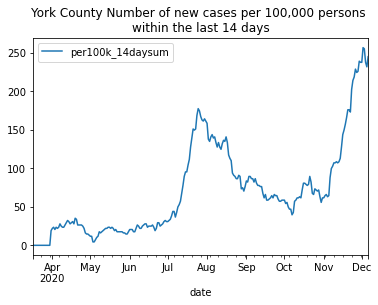

In [8]:
ph = dfy.plot(y='per100k_14daysum',x='date',title="York County Number of new cases per 100,000 persons \nwithin the last 14 days")

ph

<AxesSubplot:title={'center':'York County Cases, 14 day sum, per 100K'}, xlabel='date'>

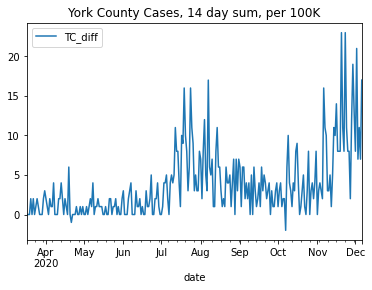

In [9]:
ph = dfy.plot(y='TC_diff',x='date',title="York County Cases, 14 day sum, per 100K")
ph

In [10]:
TOOLTIPS = [
 #   ("index", "$index"),
 #   ("date:", "$x{%F %T}"),
    ("date:", "@date{%F}"),
    ("cases/14d/100k:","@per100k_14daysum"),
 #   ("(x,y)", "($x, $y)"),
]


#p=bokeh.plotting.figure( tooltips=TOOLTIPS, x_axis_type='datetime')
p=bokeh.plotting.figure( x_axis_type='datetime',y_range=(0,260),
#                        tooltips=TOOLTIPS,formatters={"$x": "datetime"},
                        title="York County Number of new cases per 100,000 persons within the last 14 days")

    
hth = bokeh.models.HoverTool(tooltips=TOOLTIPS,
                             formatters={"$x": "datetime",
                                        "@date": "datetime"
                                        },
                             mode='vline',
                            )

print(hth)
print(hth.formatters)
p.add_tools(hth)
#hover = p.select(dict(type=bokeh.models.HoverTool))


#hover(tooltips=TOOLTIPS,
#)

p.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=5, fill_alpha=0.4, fill_color='teal'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=5,top=20, fill_alpha=0.4, fill_color='lightgreen'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=20,top=50, fill_alpha=0.4, fill_color='yellow'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=50,top=200, fill_alpha=0.4, fill_color='orange'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=200, fill_alpha=0.4, fill_color='red'))



#p.line(dfy['date'],dfy['per100k_14daysum'])
p.line(x='date', y='per100k_14daysum',source=dfy)
#p.title()

#?p.line

HoverTool(id='1035', ...)
{'$x': 'datetime', '@date': 'datetime'}


GlyphRenderer(id='1046', ...)

In [11]:
bokeh.plotting.show(p)

In [12]:
bokeh.plotting.output_file('docs/YorkCountyCovidMetric_plot.html', mode='inline')
bokeh.plotting.save(p)

# needs geckodriver  -- have it in conda env py3plot
bokeh.io.export_png(p, filename="docs/YorkCountyCovidMetric_plot.png")



'/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_plot.png'

In [13]:
# Save notebook as a python script:
! jupyter nbconvert --to script *.ipynb

[NbConvertApp] Converting notebook AllCountyCovidMetric.ipynb to script
[NbConvertApp] Writing 12810 bytes to AllCountyCovidMetric.py
[NbConvertApp] Converting notebook CovidStates.ipynb to script
[NbConvertApp] Writing 8532 bytes to CovidStates.py
[NbConvertApp] Converting notebook YorkCountyCovidMetric.ipynb to script
[NbConvertApp] Writing 4321 bytes to YorkCountyCovidMetric.py
